# Linear Temperature Gradient T(z)

In [1]:
# libraries
from dataclasses import dataclass
import numpy as np
from scipy import constants as const
import matplotlib.pyplot as plt
import pandas as pd

@dataclass
class ModelParams:
    # Temperature baseline and gradient
    Temp_0: float = 300.0
    TempGradient: float = 0.02

    # Geometry and timing
    z_min: float = 0.0
    z_max: float = 100.0
    InterrogationTime: float = 1.0
    GravAcc: float = 9.80665

    # Laser wavevector (Sr clock transition)
    WaveVector: float = (2 * np.pi) / (698e-9)

    # Cloud A (bottom) and Cloud B (top)
    A_z0: float = 0.0
    A_v0: float = +40.0
    B_z0: float = 100.0
    B_v0: float = -20.0

    # Constants
    h_bar: float = const.h / (2 * np.pi)
    c: float = const.c
    w0: float =  2 * np.pi * 4.29228e14


params = ModelParams()

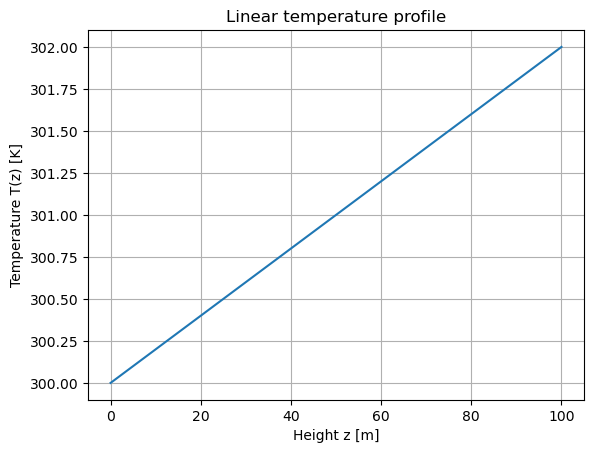

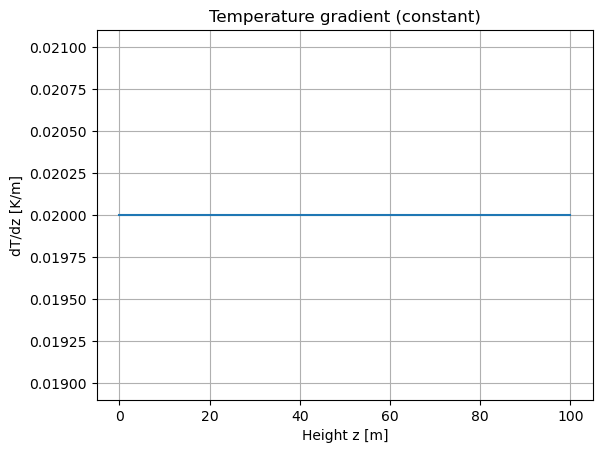

In [3]:
# Linear temperature model
def LinearTempModel(z, T0, G, z_ref = 0.0):
    return T0 + G*(z-z_ref)

def GradientLinearTempModel(z, G):
    return np.full_like(z,G)              # np.full_like(array, value): goves back an array with the exact shape of input, but now all with the values equalling value input


# Defining vertical height array
z = np.linspace(0, 100, 200)
Tz = LinearTempModel(z, params.Temp_0, params.TempGradient)
dT_dz = GradientLinearTempModel(z, params.TempGradient)

plt.figure()
plt.plot(z, Tz)
plt.xlabel("Height z [m]")
plt.ylabel("Temperature T(z) [K]")
plt.title("Linear temperature profile")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(z, dT_dz)
plt.xlabel("Height z [m]")
plt.ylabel("dT/dz [K/m]")
plt.title("Temperature gradient (constant)")
plt.grid(True)
plt.show()

In [190]:
# --- constants and BBR coefficients (Sr-87 clock) ---
h = const.h
hbar = const.hbar
c = const.c
nu0 = 4.29228e14                  # clock frequency
DeltaE = h * nu0
amu = const.physical_constants["atomic mass constant"][0]
m_Sr87 = 86.9088775 * amu         # kg (Sr-87 atomic mass)
c1 = -2.0                         # Hz  (BBR shift coefficient for |g>)
c2 = -4.0                         # Hz  (BBR shift coefficient for |e>)
Delta_c = c2 - c1                 # ~ -2 Hz
Delta_v0 = params.A_v0 - params.B_v0
T = params.InterrogationTime

# Defining the BBR mean acceleration, differential acceleration and scaled differential acceleration

def BBR_MeanAcceleration(T, G):
    # ā = (2h/m) (c1+c2) (T^3 / 300^4) * ∂T/∂z
    return (2*h/m_Sr87) * (c1 + c2) * (T/300.0)**3 * (G/300.0)

def BBR_DifferentialAcceleration(T, G):
    # δa = -(4h/m) (c2-c1) (T^3 / 300^4) * ∂T/∂z
    return -(4*h/m_Sr87) * (Delta_c) * (T/300.0)**3 * (G/300.0)

def BBR_DiffAcc_mdm(T, G):
    # (m/Δm) δa = (4 c^2/ν0) (c2-c1) (T^3 / 300^4) * ∂T/∂z
    return -(4*c**2/nu0) * (Delta_c) * (T/300.0)**3 * (G/300.0)

# --- trajectories (you already have these) ---
def trajectory(t, z0, v0, g):
    return z0 + v0*t - 0.5*g*t**2

def cloud_trajectory(z0, v0, n_samples):
    Tpulse = params.InterrogationTime
    t = np.linspace(0, 2*Tpulse, n_samples)
    z = trajectory(t, z0, v0, params.GravAcc)
    Tz = LinearTempModel(z, params.Temp_0, params.TempGradient)
    Gz = GradientLinearTempModel(z, params.TempGradient)  # constant array

    a_mean = BBR_MeanAcceleration(Tz, Gz)
    diff_a = BBR_DifferentialAcceleration(Tz, Gz)
    diff_a_mdm = BBR_DiffAcc_mdm(Tz, Gz)   
    return dict(t=t, z=z, T=Tz, a_mean=a_mean, diff_a=diff_a, diff_a_mdm=diff_a_mdm)

cloud_A = cloud_trajectory(params.A_z0, params.A_v0, 2001)
cloud_B = cloud_trajectory(params.B_z0, params.B_v0, 2001)

# time averaged integration of accelerations over time
def time_average(values, t):
    return np.trapz(values, t) / (t[-1]-t[0])


# getting time averaged mean accelerations for cloud A and cloud B
a_mean_A = time_average(cloud_A["a_mean"], cloud_A["t"])
a_mean_B = time_average(cloud_B["a_mean"], cloud_B["t"])
# getting differential acceleration for cloud A and B
diff_a_A = time_average(cloud_A["diff_a"], cloud_A["t"])
diff_a_B = time_average(cloud_B["diff_a"], cloud_B["t"])
# getting m/dm scaled differential accelerations for cloud A and cloud B
diff_a_mdm_A = time_average(cloud_A["diff_a_mdm"], cloud_A["t"])
diff_a_mdm_B = time_average(cloud_B["diff_a_mdm"], cloud_B["t"])

# Now calculating the difference
a_mean_diff = a_mean_A - a_mean_B
Difference_Cloud_DiffAcc = diff_a_A - diff_a_B
Difference_Cloud_DiffAcc_mdm = diff_a_mdm_A - diff_a_mdm_B

# phases
phi_mean_BBR = -2*(DeltaE/hbar) * (Delta_v0 * a_mean_diff) * (T**2) / (c**2)
phi_diff_BBR = -2*(DeltaE/hbar) * (Delta_v0 * Difference_Cloud_DiffAcc) * (T**2) / (c**2)
phi_diff_mdm_BBR = -2*(DeltaE/hbar) * (Delta_v0 * Difference_Cloud_DiffAcc_mdm) * (T**2) / (c**2)
print(phi_diff_mdm_BBR)

0.003239928026996342


In [192]:
# coefficients from paper
mean_a_coeff = (2*const.h)/(m_Sr87)*(abs(c1+c2)*(1/300)*(1/100))
print(f'a_mean coefficient = {mean_a_coeff}')
diff_a_coeff = (4*c**2)/(nu0) * (abs(c2-c1))*(1/300)*(1/100)
print(f'da coefficient = {diff_a_coeff}')

# Others
m_dm = (m_Sr87*c**2)/(const.h*nu0)
print(f'm/dm = {m_dm:2e}')


a_mean coefficient = 1.8365501104406268e-12
da coefficient = 0.055837002167414836
m/dm = 4.560480e+10


In [194]:
# per-cloud gravity phase (time dilation)
phi_GR_A = -2*(DeltaE/hbar) * ( (params.A_v0 * params.GravAcc) * T**2 + (params.GravAcc**2) * T**3 ) / (c**2)
phi_GR_B = -2*(DeltaE/hbar) * ( (params.B_v0 * params.GravAcc) * T**2 + (params.GravAcc**2) * T**3 ) / (c**2)

# gradiometer gravity signal
phi_GR_grad = phi_GR_A - phi_GR_B
# goes to
phi_GR_true = -2*(DeltaE/hbar) * ( (params.A_v0 - params.B_v0) * params.GravAcc ) * T**2 / (c**2)


In [206]:
g = params.GravAcc

print("\n================= BBR ACCELERATIONS =================")
print(f"⟨ā_BBR⟩ CLoud A = {a_mean_A:.3e} m/s^2")
print(f"⟨ā_BBR⟩ Cloud B = {a_mean_B:.3e} m/s^2")
print(f"Δā_BBR Difference between A and B = {a_mean_diff:.3e} m/s^2")

print("\n⟨δa_BBR⟩ (state-dependent differential acceleration):")
print(f"⟨δa⟩ Cloud A = {diff_a_A:.3e} m/s^2")
print(f"⟨δa⟩ Cloud B = {diff_a_B:.3e} m/s^2")
print(f"Δ⟨δa⟩ Difference between A and B = {Difference_Cloud_DiffAcc:.3e} m/s^2")

print("\n⟨δa_m/dm⟩ (m/dm scaled differential acceleration):")
print(f"⟨δa_mdm⟩ Scaled Cloud A = {diff_a_mdm_A:.5f} m/s^2")
print(f"⟨δa_mdm⟩ Scaled Cloud B = {diff_a_mdm_B:.5f} m/s^2")
print(f"Δ⟨δa_mdm⟩ Scaled Difference between A and B= {Difference_Cloud_DiffAcc_mdm:.10f} m/s^2")

print("\n--- All time averaged ---")
print(f"⟨δa_mdm⟩_A/g Normalised to g, differential acceleration for cloud A= {diff_a_mdm_A/g:.5f}")
print(f"⟨δa_mdm⟩_B/g Normalised to g, differential acceleration for cloud A= {diff_a_mdm_B/g:.5f}")
print(f"Δ⟨δa_mdm⟩/g Normalised to g, difference A and B= {Difference_Cloud_DiffAcc_mdm/g:.10f}")

print("\n================= PHASE SHIFTS =================")
#print(f"Δφ̄_BBR (Plugging mean acceleration difference into eqn 13) = {phi_mean_BBR:.3e} rad")
#print(f"Δφ_diff_BBR (Plugging differential acceleration into eqn 13) = {phi_diff_BBR:.3e} rad")
print(f"Δφ_diff_mdm_BBR (Plugging δa_mdm into eqn 13) = {phi_diff_mdm_BBR:.3e} rad")

print("\n================= NORMALISED TO TRUE GR SIGNAL =================")
print(f"φ_true_GR_A = {phi_GR_A:.3f} rad")
print(f"φ_true_GR_B = {phi_GR_B:.3f} rad")
print(f"Δφ_true_GR = {phi_GR_true:.3f} rad")

print(f"Δφ_clock_BBR / Δφ_true_GR = {(phi_diff_mdm_BBR / phi_GR_true):.3e}")




================= BBR ACCELERATIONS =================
⟨ā_BBR⟩ CLoud A = -3.698e-12 m/s^2
⟨ā_BBR⟩ Cloud B = -3.727e-12 m/s^2
Δā_BBR Difference between A and B = 2.959e-14 m/s^2

⟨δa_BBR⟩ (state-dependent differential acceleration):
⟨δa⟩ Cloud A = 2.465e-12 m/s^2
⟨δa⟩ Cloud B = 2.485e-12 m/s^2
Δ⟨δa⟩ Difference between A and B = -1.973e-14 m/s^2

⟨δa_m/dm⟩ (m/dm scaled differential acceleration):
⟨δa_mdm⟩ Scaled Cloud A = 0.11242 m/s^2
⟨δa_mdm⟩ Scaled Cloud B = 0.11332 m/s^2
Δ⟨δa_mdm⟩ Scaled Difference between A and B= -0.0008997619 m/s^2

--- All time averaged ---
⟨δa_mdm⟩_A/g Normalised to g, differential acceleration for cloud A= 0.01146
⟨δa_mdm⟩_B/g Normalised to g, differential acceleration for cloud A= 0.01156
Δ⟨δa_mdm⟩/g Normalised to g, difference A and B= -0.0000917502

================= PHASE SHIFTS =================
Δφ_diff_mdm_BBR (Plugging δa_mdm into eqn 13) = 3.240e-03 rad

================= NORMALISED TO TRUE GR SIGNAL =================
φ_true_GR_A = -29.313 rad
φ_true

In [175]:
# ================= CLOCK-INTEGRAL METHOD  =================
# Sensitivity function for π/2 – π – π/2 (Ramsey-like) sequence:
# +1 on (0, T), -1 on (T, 2T)
def sensitivity_function(t, Tpulse):
    f = np.zeros_like(t)
    f[(t > 0.0) & (t < Tpulse)] = 1.0
    f[(t > Tpulse) & (t < 2*Tpulse)] = -1.0
    return f

# BBR clock shift model (Middelmann parameterization at 300 K)
DELTA_NU_STAT = -2.13023   # Hz
DELTA_NU_DYN  = -0.1476    # Hz
T0 = 300.0                 # K

def delta_nu_BBR(TK):
    # Δν(T) = Δν_stat (T/T0)^4 + Δν_dyn (T/T0)^6
    x = TK / T0
    return DELTA_NU_STAT * x**4 + DELTA_NU_DYN * x**6

# sensitivity functions on same time grids as clouds
fA = sensitivity_function(cloud_A["t"], params.InterrogationTime)
fB = sensitivity_function(cloud_B["t"], params.InterrogationTime)

# evaluate temperature on each cloud trajectory
TA = cloud_A["T"]
TB = cloud_B["T"]

# get BBR clock shifts
dnuA = delta_nu_BBR(TA)
dnuB = delta_nu_BBR(TB)

# integrate to get per cloud phase
phi_clock_A = 2*np.pi * np.trapz(fA * dnuA, cloud_A["t"])
phi_clock_B = 2*np.pi * np.trapz(fB * dnuB, cloud_B["t"])
# phase difference between clouds
phi_clock_diff = phi_clock_A - phi_clock_B

print("\n================= CLOCK-INTEGRAL METHOD (BBR) =================")
print(f"φ_clock_A = {phi_clock_A:.3f} rad")
print(f"φ_clock_B = {phi_clock_B:.3f} rad")
print(f"Δφ_clock (A−B) = {phi_clock_diff:.3f} rad")

print("\n================= COMPARISON =================")
print(f"Δφ_diff_mdm_BBR (from accel route) = {phi_diff_mdm_BBR:.3f} rad")
print(f"Ratio (Δφ_clock / Δφ_diff_mdm_BBR) = {(phi_clock_diff / phi_diff_mdm_BBR):.3f}")

print("\n================= NORMALISED TO TRUE GR SIGNAL =================")
print(f"(Δφ_clock_BBR / Δφ_true_GR) % = {(phi_clock_diff / phi_GR_true)*100:.3f} %")





================= CLOCK-INTEGRAL METHOD (BBR) =================
φ_clock_A = 0.120 rad
φ_clock_B = -0.119 rad
Δφ_clock (A−B) = 0.239 rad

================= COMPARISON =================
Δφ_diff_mdm_BBR (from accel route) = -0.003 rad
Ratio (Δφ_clock / Δφ_diff_mdm_BBR) = -73.713

================= NORMALISED TO TRUE GR SIGNAL =================
(Δφ_clock_BBR / Δφ_true_GR) % = -0.676 %


# Non-Linear Temperature Gradient: T(z) = T0 + G1*z + G2*z^2 


Running Nonlinear Temperature Case: G2 = -1.0e-06 K/m²
Gradient (dT/dz) at bottom  [K/m] = 2.000000e-02
Gradient (dT/dz) at middle  [K/m] = 1.990000e-02
Gradient (dT/dz) at top     [K/m] = 1.980000e-02


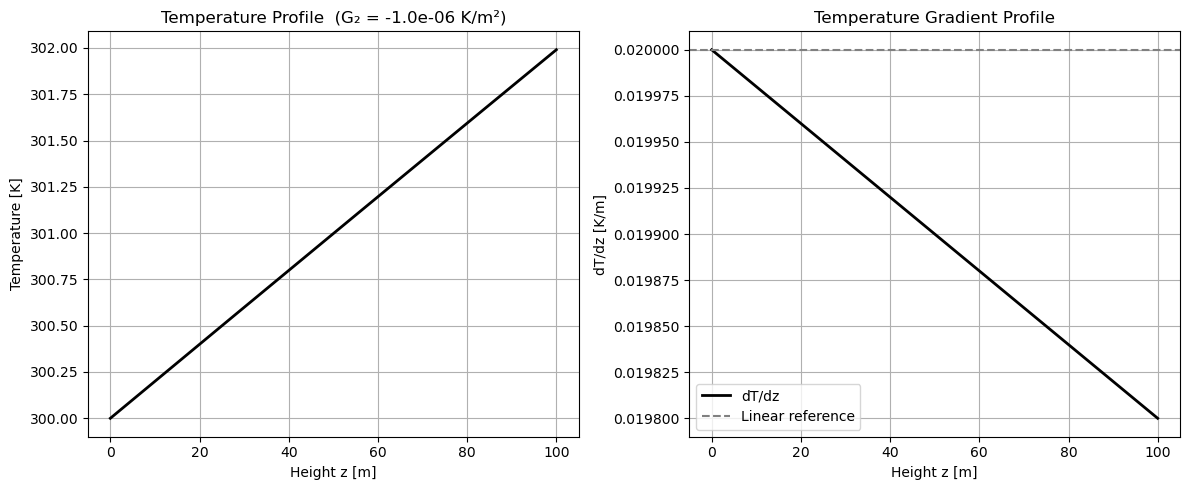


================= PHASE SHIFTS (summary) =================
Δφ̄_BBR        [rad] = -5.195726e-14
Δφ_diff_BBR     [rad] = 3.463817e-14
Δφ_diff_mdm_BBR [rad] = -1.579667e-03
Δφ_clock_BBR / Δφ_true_GR = 4.473393e-05

Running Nonlinear Temperature Case: G2 = -5.0e-07 K/m²
Gradient (dT/dz) at bottom  [K/m] = 2.000000e-02
Gradient (dT/dz) at middle  [K/m] = 1.995000e-02
Gradient (dT/dz) at top     [K/m] = 1.990000e-02


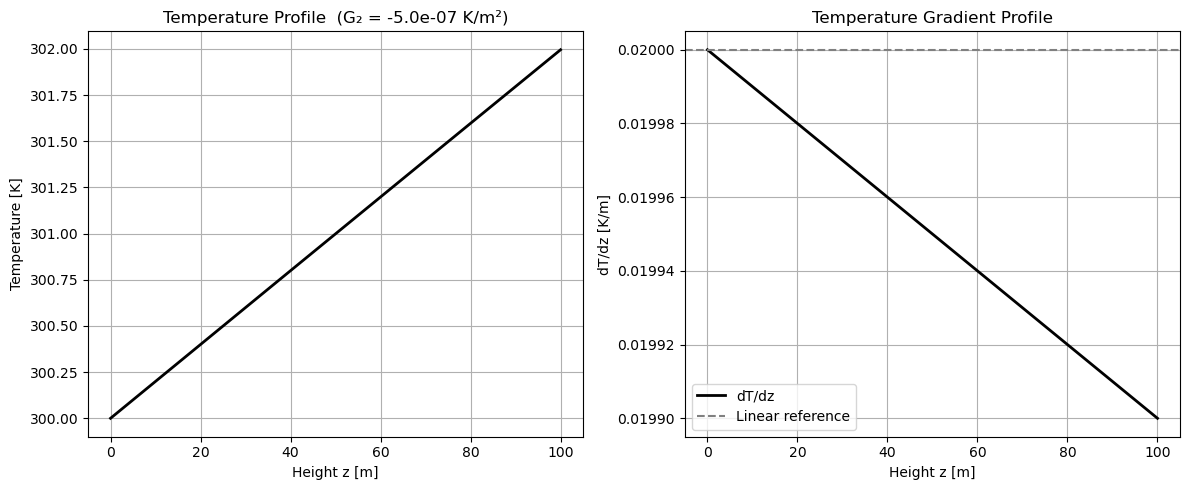


================= PHASE SHIFTS (summary) =================
Δφ̄_BBR        [rad] = -7.925998e-14
Δφ_diff_BBR     [rad] = 5.283999e-14
Δφ_diff_mdm_BBR [rad] = -2.409757e-03
Δφ_clock_BBR / Δφ_true_GR = 6.824092e-05

Running Nonlinear Temperature Case: G2 = 0.0e+00 K/m²
Gradient (dT/dz) at bottom  [K/m] = 2.000000e-02
Gradient (dT/dz) at middle  [K/m] = 2.000000e-02
Gradient (dT/dz) at top     [K/m] = 2.000000e-02


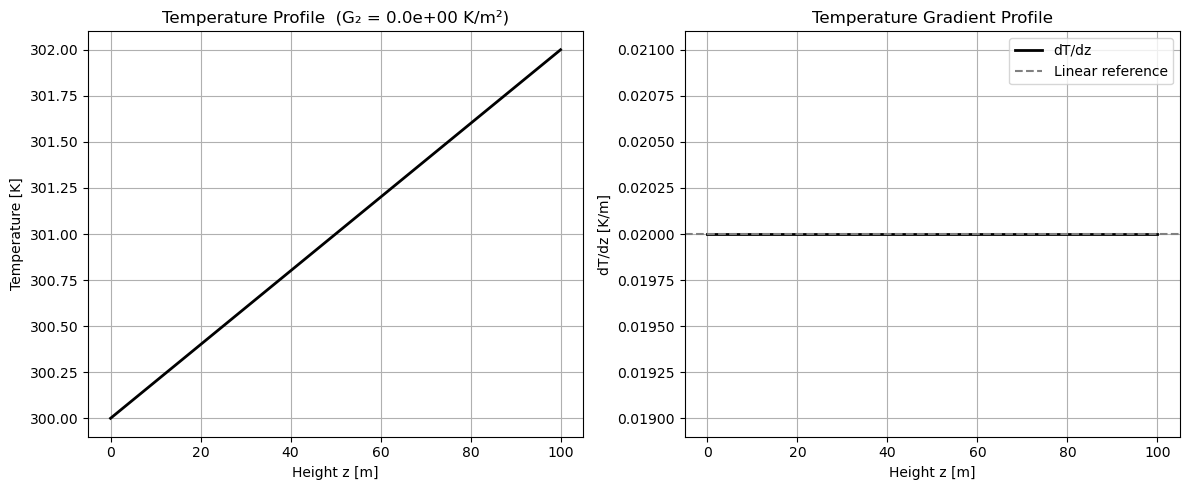


================= PHASE SHIFTS (summary) =================
Δφ̄_BBR        [rad] = -1.065654e-13
Δφ_diff_BBR     [rad] = 7.104357e-14
Δφ_diff_mdm_BBR [rad] = -3.239928e-03
Δφ_clock_BBR / Δφ_true_GR = 9.175018e-05

Running Nonlinear Temperature Case: G2 = 5.0e-07 K/m²
Gradient (dT/dz) at bottom  [K/m] = 2.000000e-02
Gradient (dT/dz) at middle  [K/m] = 2.005000e-02
Gradient (dT/dz) at top     [K/m] = 2.010000e-02


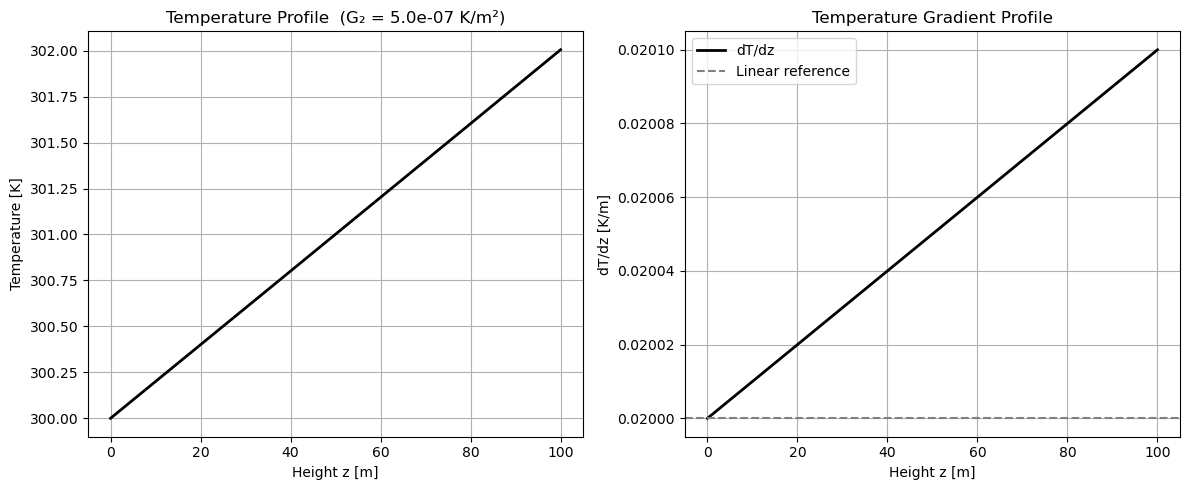


================= PHASE SHIFTS (summary) =================
Δφ̄_BBR        [rad] = -1.338734e-13
Δφ_diff_BBR     [rad] = 8.924892e-14
Δφ_diff_mdm_BBR [rad] = -4.070179e-03
Δφ_clock_BBR / Δφ_true_GR = 1.152617e-04

Running Nonlinear Temperature Case: G2 = 1.0e-06 K/m²
Gradient (dT/dz) at bottom  [K/m] = 2.000000e-02
Gradient (dT/dz) at middle  [K/m] = 2.010000e-02
Gradient (dT/dz) at top     [K/m] = 2.020000e-02


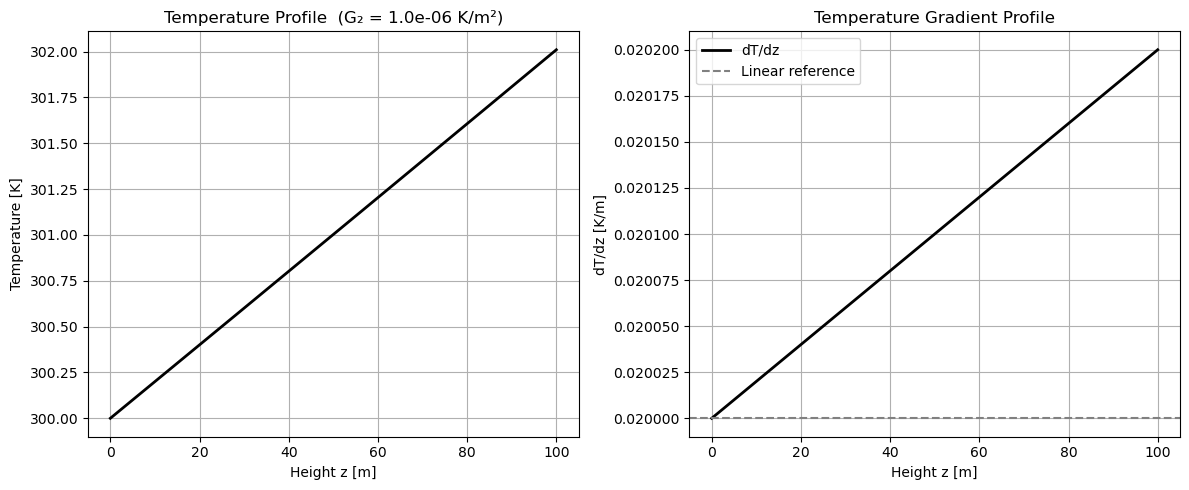


================= PHASE SHIFTS (summary) =================
Δφ̄_BBR        [rad] = -1.611840e-13
Δφ_diff_BBR     [rad] = 1.074560e-13
Δφ_diff_mdm_BBR [rad] = -4.900511e-03
Δφ_clock_BBR / Δφ_true_GR = 1.387755e-04


In [99]:
# ============================================================
# NONLINEAR TEMPERATURE T(z) = T0 + zG1 + z^2G2
# ============================================================
def NonlinearTempModel(z, T0, G1, G2=0.0, G3=0.0):
    """Nonlinear temperature model: T(z) = T0 + G1*z + G2*z^2 + G3*z^3"""
    return T0 + G1*z + G2*z**2 #+ G3*z**3

def GradientNonlinearTempModel(z, G1, G2=0.0, G3=0.0):
    """Temperature gradient dT/dz = G1 + 2*G2*z + 3*G3*z^2"""
    return G1 + 2*G2*z #+ 3*G3*z**2

def cloud_trajectory_nonlinear(z0, v0, n_samples, G1, G2=0.0, G3=0.0):
    """Compute trajectory and non linear temp rpofile"""
    Tpulse = params.InterrogationTime
    t = np.linspace(0, 2*Tpulse, n_samples)
    z = trajectory(t, z0, v0, params.GravAcc)
    Tz = NonlinearTempModel(z, params.Temp_0, G1, G2, G3)
    Gz = GradientNonlinearTempModel(z, G1, G2, G3)
    a_mean = BBR_MeanAcceleration(Tz, Gz)
    diff_a = BBR_DifferentialAcceleration(Tz, Gz)
    diff_a_mdm = BBR_DiffAcc_mdm(Tz, Gz)
    return dict(t=t, z=z, T=Tz, a_mean=a_mean, diff_a=diff_a, diff_a_mdm=diff_a_mdm)


curvatures = np.array([0.0, 1e-6, -1e-6, 5e-7, -5e-7])
curvatures = np.sort(curvatures)

T = params.InterrogationTime
Delta_v0 = params.A_v0 - params.B_v0
g = params.GravAcc

# Common z-grid for temperature plots
z_plot = np.linspace(0, 100, 1000)

for G2 in curvatures:
    print("\n============================================================")
    print(f"Running Nonlinear Temperature Case: G2 = {G2:.1e} K/m²")
    print("============================================================")

    G1 = params.TempGradient
    G3 = 0.0

    # Temperature profiles over entire shaft
    Tz_plot = NonlinearTempModel(z_plot, params.Temp_0, G1, G2, G3)
    dTdz_plot = GradientNonlinearTempModel(z_plot, G1, G2, G3)

    # Gradients at reference heights
    grad_bottom = GradientNonlinearTempModel(0, G1, G2, G3)
    grad_mid = GradientNonlinearTempModel(50, G1, G2, G3)
    grad_top = GradientNonlinearTempModel(100, G1, G2, G3)
    print(f"Gradient (dT/dz) at bottom  [K/m] = {grad_bottom:.6e}")
    print(f"Gradient (dT/dz) at middle  [K/m] = {grad_mid:.6e}")
    print(f"Gradient (dT/dz) at top     [K/m] = {grad_top:.6e}")

    # ============================================================
    # PLOTS (NO CLOUD PATHS)
    # ============================================================

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ---- Temperature profile ----
    axes[0].plot(z_plot, Tz_plot, 'k', lw=2)
    axes[0].set_xlabel("Height z [m]")
    axes[0].set_ylabel("Temperature [K]")
    axes[0].set_title(f"Temperature Profile  (G₂ = {G2:.1e} K/m²)")
    axes[0].grid(True)

    # ---- Temperature gradient ----
    axes[1].plot(z_plot, dTdz_plot, 'k', lw=2, label="dT/dz")
    axes[1].axhline(params.TempGradient, color='gray', ls='--', label="Linear reference")
    axes[1].set_xlabel("Height z [m]")
    axes[1].set_ylabel("dT/dz [K/m]")
    axes[1].set_title("Temperature Gradient Profile")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # ============================================================
    # COMPUTE AND PRINT SUMMARY (SAME AS BEFORE)
    # ============================================================
    cloud_A = cloud_trajectory_nonlinear(params.A_z0, params.A_v0, 2001, G1, G2, G3)
    cloud_B = cloud_trajectory_nonlinear(params.B_z0, params.B_v0, 2001, G1, G2, G3)

    a_mean_A = time_average(cloud_A["a_mean"], cloud_A["t"])
    a_mean_B = time_average(cloud_B["a_mean"], cloud_B["t"])
    diff_a_A = time_average(cloud_A["diff_a"], cloud_A["t"])
    diff_a_B = time_average(cloud_B["diff_a"], cloud_B["t"])
    diff_a_mdm_A = time_average(cloud_A["diff_a_mdm"], cloud_A["t"])
    diff_a_mdm_B = time_average(cloud_B["diff_a_mdm"], cloud_B["t"])

    a_mean_diff = a_mean_A - a_mean_B
    Difference_Cloud_DiffAcc = diff_a_A - diff_a_B
    Difference_Cloud_DiffAcc_mdm = diff_a_mdm_A - diff_a_mdm_B

    phi_mean_BBR = -2*(DeltaE/hbar) * (Delta_v0 * a_mean_diff) * (T**2) / (c**2)
    phi_diff_BBR = -2*(DeltaE/hbar) * (Delta_v0 * Difference_Cloud_DiffAcc) * (T**2) / (c**2)
    phi_diff_mdm_BBR = -2*(DeltaE/hbar) * (Delta_v0 * Difference_Cloud_DiffAcc_mdm) * (T**2) / (c**2)
    phi_GR_true = -2*(DeltaE/hbar) * ((params.A_v0 - params.B_v0) * g) * T**2 / (c**2)

    print("\n================= PHASE SHIFTS (summary) =================")
    print(f"Δφ̄_BBR        [rad] = {phi_mean_BBR:.6e}")
    print(f"Δφ_diff_BBR     [rad] = {phi_diff_BBR:.6e}")
    print(f"Δφ_diff_mdm_BBR [rad] = {phi_diff_mdm_BBR:.6e}")
    print(f"Δφ_clock_BBR / Δφ_true_GR = {phi_diff_mdm_BBR / phi_GR_true:.6e}")
